In [1]:
from glob import glob
import pandas as pd
import hdbscan
import sklearn.feature_extraction.text
#import sklearn.decomposition
import sklearn.metrics
import umap
import umap.plot
import os
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from toolz import itertoolz, compose
from toolz.curried import map as cmap, sliding_window, pluck
from collections import Counter
import numpy as np
from scipy import sparse
from bokeh.plotting import save
from bokeh.io import export_png
from bokeh.models.annotations import Title

class SkipGramVectorizer(sklearn.feature_extraction.text.CountVectorizer):
    def build_analyzer(self):    
        preprocess = self.build_preprocessor()
        stop_words = self.get_stop_words()
        tokenize = self.build_tokenizer()
        return lambda doc: self._word_skip_grams(
                compose(tokenize, preprocess, self.decode)(doc),
                stop_words)

    def _word_skip_grams(self, tokens, stop_words=None):
        window_size = 5
        # handle stop words
        if stop_words is not None:
            tokens = [w for w in tokens if w not in stop_words]

        return compose(cmap(' '.join), pluck([0, 2]), sliding_window(window_size))(tokens)


def comma_tokenizer(instring):
    return [x.strip() for x in instring.split(',')]
    
    
def counter_to_count_array(counter, n_values=10):
   raw_list = sorted(list(counter.values()), reverse=True)
   return np.concatenate([raw_list, np.zeros(n_values - len(raw_list), dtype=int)])


def dataframe_of_counters_to_array(df, counter_col_name='counters'):
   n_values = df[counter_col_name].map(len).max()
   return np.vstack(df[counter_col_name].apply(counter_to_count_array, args=(n_values,)))


def plot_relative_bar_chart(df, counter_col_name='counters', label_col='label'):
   fig = plt.figure(figsize=(8, 0.5 * df.shape[0]))
   ax = fig.add_subplot(111)
   relative_df = pd.DataFrame(dataframe_of_counters_to_array(df, counter_col_name))
   relative_df = (relative_df.T / relative_df.sum(axis=1)).T
   relative_df.index = df[label_col]
   ax = relative_df.plot.barh(stacked=True, legend=False, ax=ax, width=0.95)
   ax.set(xticks=[])

### Edit input_file_glob and base_filename variables

<code>input_file_glob</code> should match the set of files you'd like to parse into your input strings.  Structure is: 

    .../<label-dir>/\<instance-file\>
    
This notebook will write a number of output files making use of your <code>base_filename</code>




In [2]:
input_file_glob = "/mnt/spaceport/malfinder-1/inputFilesTouched/10000/FE_WINXP_SP3/*/*"
base_filename = "malwares_sg_actions_umap_10k_stemmed"

In [3]:
tmp_filename_meta = '_'.join([base_filename,'meta.csv'])
tmp_filename_features = '_'.join([base_filename,'features.npz'])
output_filename = '_'.join([base_filename,'output.csv'])
output_html_filename = '_'.join([base_filename,'plot.html'])
output_png_filename = '_'.join([base_filename,'plot.png'])

#filelist=glob("/mnt/spaceport/malfinder-1/inputFiles/10000/FE_WINXP_SP3/*/*", recursive=True)
#filelist=glob("/mnt/spaceport/malfinder-1/inputFilesTouched/10000/FE_WINXP_SP3/*/*", recursive=True)
filelist=glob(input_file_glob, recursive=True) #50K touched files
print("files:", len(filelist))

files: 10000


### Here we will read our files from disk and use a variation on scikit-learns CountVectorizer to convert from sentences to a sparse matrix of tokens.

We use a SkipGramVectorizer with a window of 5 to extract features from variable length sequences of text.  This will represent every sequence via a set of bigrams that appear within 5 tokens of each other in your sequence.  

One should note that here sequences and tokens are fully generic.  They can equall refer to sequences of libraries, words, commands, etc...

We split sentences on commas so if you'd like to reuse this code as written pack your tokens together into comma delimeted sequences.

This should be the only code you need to modify in order to use this notebook on data of a different format than what you see here.

In [4]:
%%time

if os.path.isfile(tmp_filename_meta) and os.path.isfile(tmp_filename_features):
    print("saving time")
    meta = pd.read_csv(tmp_filename_meta)
    features = sparse.load_npz(tmp_filename_features)
else: 
    seqs = []
    file_path=[]
    file_name=[]
    labels=[]
    i = 0
    for file in filelist: #[0:100]:
        if (i % 100 == 0):
            print('\r' + str(int((i / len(filelist)) * 100)) + "%", end='')
        i+=1
        if os.path.getsize(file) == 0:
            continue
        data = pd.read_csv(file, sep=',')
        #malwares.append(','.join(data.iloc[:,1]))
        data[3] = data.iloc[:,1].map(str) + ' ' + data.iloc[:,2].map(str)
        #print(data)
        seqs.append(','.join(data.iloc[:,3]))
        label = file.split('/')
        labels.append(label[len(label)-2])
        file_name.append(label[len(label)-1])
        file_path.append(file)
    print('\rDone', end='')
    meta=pd.DataFrame({'labels':labels, 'file_path':file_path, 'file_name':file_name})
    
    meta.to_csv(tmp_filename_meta, index=False)
    features = SkipGramVectorizer(tokenizer=comma_tokenizer).fit_transform(seqs)
    sparse.save_npz(tmp_filename_features, features)
    print(' and Saved')


Done and Saved
CPU times: user 2min 42s, sys: 9.99 s, total: 2min 52s
Wall time: 3min 11s


### Embed your data

Here we use UMAP (a non-linear dimension reduction technique) for embedding our data into 2 dimensions.

This serves the dual purpose of making our follow up clustering more efficient (indeed possible) as well as allowing easy visualization of the data's underlying structure.

In [5]:
%%time
umap_model = umap.UMAP(n_components=2, n_neighbors=10, metric='cosine').fit(features)
umap_embedding = umap_model.embedding_

/home/spark/anaconda3/envs/umapdev/lib/python3.6/site-packages/umap_learn-0.4.0-py3.6.egg/umap/spectral.py:228: UserWarning: Embedding a total of 25 separate connected components using meta-embedding (experimental)


CPU times: user 7min 12s, sys: 15.3 s, total: 7min 28s
Wall time: 5min 48s


### Cluster your data

Now that our data is embedded in 2 dimensions we can easily group our data into dense clusters.  We select the hdbscan algorithm because it is fast, efficient $O(nlog(n))$ and robust to background noise.  You may of course make use of the algorithm of your choice here.

In [6]:
%%time
clusterer = hdbscan.HDBSCAN(min_cluster_size=15)
clusterer.fit(umap_embedding)
pd.Series(clusterer.labels_).value_counts()
#clusterer.labels_

CPU times: user 3 s, sys: 112 ms, total: 3.11 s
Wall time: 695 ms


### Analyse our clusters

We have labels that we've extracted from our filenames.  Let's use these to compute a few evaluative measures on our clusters.

In [7]:
cluster_labels = pd.DataFrame({"label":clusterer.labels_, "truelabels":meta.labels})
cluster_scores = cluster_labels.groupby(['label']).truelabels.aggregate(lambda x: Counter(x)).reset_index()

In [8]:
cluster_scores['most_common_freq'] = cluster_scores.truelabels.map(lambda x: x.most_common(n=1)[0][1])
cluster_scores['most_common_label'] = cluster_scores.truelabels.map(lambda x: x.most_common(n=1)[0][0])
cluster_scores['cluster_size'] = cluster_scores.truelabels.map(lambda x: len(list(x.elements())))
cluster_scores['purity'] = cluster_scores.most_common_freq/cluster_scores.cluster_size
cluster_scores.head()

,label,truelabels,most_common_freq,most_common_label,cluster_size,purity
0,-1,"{'filetour': 3, 'pcclient': 1, 'mira': 10, 'au...",270,virut,854,0.316159
1,0,{'parite': 17},17,parite,17,1.000000
2,1,"{'sality': 4, 'virut': 12, 'browsefox': 9}",12,virut,25,0.480000
3,2,"{'parite': 41, 'fearso': 1, 'virut': 1, 'ardam...",41,parite,44,0.931818
4,3,{'parite': 28},28,parite,28,1.000000


### Aggregate our results and export.

This exports a csv with one row per sequence along with cluster_id, input label, x,y co-ordinates and a small number of cluster characteristics for the cluster that each sequence belongs.

In [9]:
export_data = pd.DataFrame({'file_name':meta.file_name, 'cluster_id':clusterer.labels_, 'input_label':meta.labels, 
                            'cluster_membership_strength':clusterer.probabilities_,
                            'x':umap_embedding[:,0],
                            'y':umap_embedding[:,1],
                            'file_path':meta.file_path})
size_map = {x:y for x,y in zip(cluster_scores.label, cluster_scores.cluster_size)}
export_data['cluster_size'] = export_data.cluster_id.map(size_map)

purity_map = {x:y for x,y in zip(cluster_scores.label, cluster_scores.purity)}
export_data['cluster_purity'] = export_data.cluster_id.map(purity_map)

majority_map = {x:y for x,y in zip(cluster_scores.label, cluster_scores.most_common_label)}
export_data['majority_label'] = export_data.cluster_id.map(majority_map)

export_data.sort_values(['cluster_id', 'cluster_membership_strength'], inplace=True)
export_data.to_csv(output_filename)
export_data.head()

,file_name,cluster_id,input_label,cluster_membership_strength,x,y,file_path,cluster_size,cluster_purity,majority_label
1,01c00166ec107270a1c325162b32c350.csv,-1,filetour,0.0,8.545569,16.781601,/mnt/spaceport/malfinder-1/inputFilesTouched/1...,854,0.316159,virut
2,046534a9f8740ff4bf5a0843ac5fdc9e.csv,-1,filetour,0.0,8.495146,16.741455,/mnt/spaceport/malfinder-1/inputFilesTouched/1...,854,0.316159,virut
5,03997a646cf67ee690e3ca45f6eb858a.csv,-1,filetour,0.0,8.532746,16.771942,/mnt/spaceport/malfinder-1/inputFilesTouched/1...,854,0.316159,virut
6,042bd33711ec81bce9cc2fbaa147f59f.csv,-1,pcclient,0.0,5.653535,12.553232,/mnt/spaceport/malfinder-1/inputFilesTouched/1...,854,0.316159,virut
7,05161371e900a6075b8db986d8852216.csv,-1,mira,0.0,20.999132,-4.272933,/mnt/spaceport/malfinder-1/inputFilesTouched/1...,854,0.316159,virut


#### Visualize the purity distribution of our clusters

/home/spark/anaconda3/envs/umapdev/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Cluster Purity Distribution')

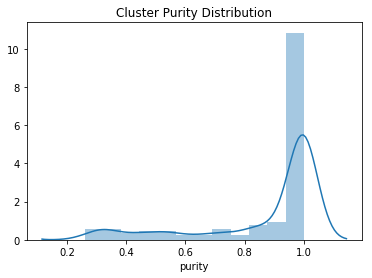

In [10]:
pdp = sns.distplot(cluster_scores.purity)
pdp.set_title('Cluster Purity Distribution')

In [11]:
sklearn.metrics.adjusted_rand_score(np.array(meta.labels)[clusterer.labels_ != -1], clusterer.labels_[clusterer.labels_ != -1])

0.3041728700902886

In [12]:
weighted_avg_purity = cluster_scores.purity @ (cluster_scores.cluster_size / cluster_scores.cluster_size.sum())
weighted_avg_purity

0.8588833562877425

### Plot each individual cluster purity as a horizontal bar chart

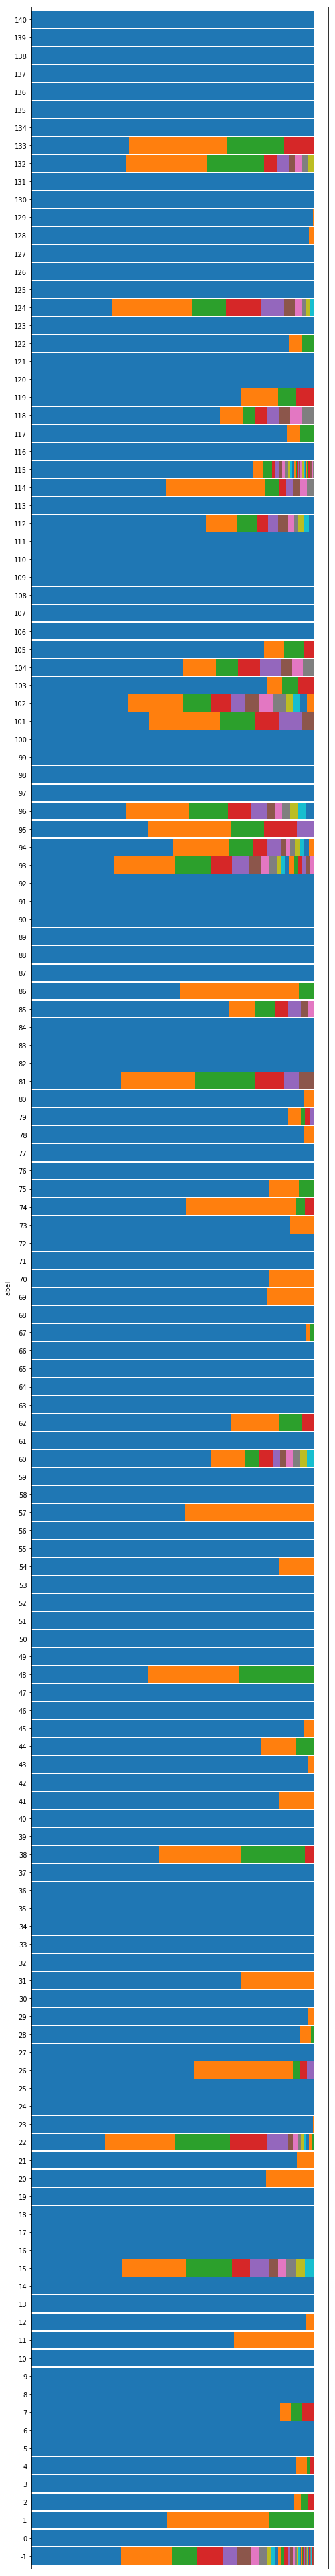

In [13]:
plot_relative_bar_chart(cluster_scores, 'truelabels')

### Create an interactive plot of the clusters

In [14]:
top_ten = pd.Series(meta.labels).value_counts()
rank_map = {x:x if y<9 else 'other' for x,y in zip(top_ten.index,range(len(top_ten)))}
top_ten_labels = pd.Series(meta.labels).map(rank_map)

df = pd.DataFrame({'seq':meta.file_name,'label':meta.labels, 'cluster':clusterer.labels_})
col = umap.plot._to_hex(sns.color_palette('Paired', 9))
colour_map = {x:col[y] if y<9 else '#999999' for x,y in zip(top_ten.index,range(len(top_ten)))}

umap_plot = umap.plot.interactive(umap_model, labels=top_ten_labels, hover_data=df, color_key=colour_map, background='black')
#title = Title()
#title.text = 'Interactive Scatterplot of Sequences' + base_filename
#title.text_color('#FFFFFF')
#umap_plot.title = title

save(umap_plot, filename=output_html_filename)

/home/spark/anaconda3/envs/umapdev/lib/python3.6/site-packages/bokeh/io/saving.py:123: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/home/spark/anaconda3/envs/umapdev/lib/python3.6/site-packages/bokeh/io/saving.py:136: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


'/home/spark/umapdev/notebooks/malwares_sg_actions_umap_10k_stemmed_plot.html'

### Output a png of the plot for use in fancy presentations

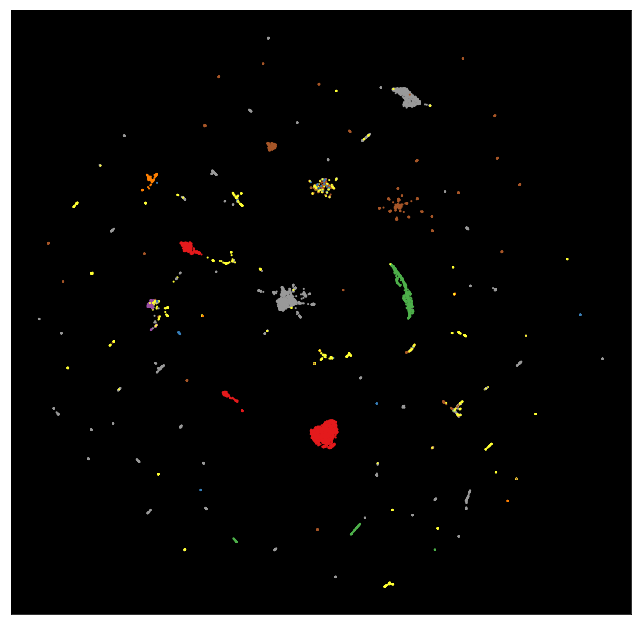

In [27]:
png_plot = umap.plot.points(umap_model, labels=top_ten_labels, color_key_cmap='Set1', background='black')
#png_plot.figure.savefig(output_png_filename)